"""
# Análisis de Dataset de Imágenes de Celebridades
## Clasificación Binaria: Natalie Portman vs Scarlett Johansson

### Objetivo del Proyecto
Realizar un análisis exhaustivo de imágenes de dos actrices para preparar un dataset 
de clasificación binaria, incluyendo exploración, preprocesamiento y aumento de datos.

### Dataset
- **Fuente**: [Kaggle Celebrity Face Image Dataset](https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset/data)
- **Clases seleccionadas**: Natalie Portman y Scarlett Johansson
- **Total de artistas en dataset**: 18
- **Imágenes por artista**: 100
- **Formato**: JPG

### Estructura del Análisis
1. Exploración General del Dataset
2. Análisis Estadístico
3. Preprocesamiento Básico
4. Aumento de Datos
5. Limpieza y Control de Calidad
"""

# Importación de librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import cv2
from collections import Counter
import hashlib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(" Librerías importadas correctamente")

 Librerías importadas correctamente


In [3]:
# Configurar la ruta del dataset (AJUSTAR SEGÚN TU SISTEMA)
DATASET_PATH = "Celebrity_Faces_Dataset"  
CLASSES = ['Natalie Portman', 'Scarlett Johansson']

# Crear diccionario para almacenar información
dataset_info = {
    'paths': [],
    'labels': [],
    'sizes': [],
    'formats': [],
    'channels': []
}

def load_dataset_info(base_path, classes):
    """
    Carga información básica del dataset sin cargar todas las imágenes en memoria
    """
    for class_name in classes:
        class_path = os.path.join(base_path, class_name)
        if not os.path.exists(class_path):
            print(f" Advertencia: No se encuentra la carpeta {class_name}")
            continue
            
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            dataset_info['paths'].append(img_path)
            dataset_info['labels'].append(class_name)
            
            try:
                with Image.open(img_path) as img:
                    dataset_info['sizes'].append(img.size)
                    dataset_info['formats'].append(img.format)
                    dataset_info['channels'].append(len(img.getbands()))
            except Exception as e:
                print(f"Error al leer {img_file}: {e}")
                dataset_info['sizes'].append(None)
                dataset_info['formats'].append(None)
                dataset_info['channels'].append(None)
    
    return pd.DataFrame(dataset_info)

# Cargar información del dataset
print("Cargando información del dataset...")
df_info = load_dataset_info(DATASET_PATH, CLASSES)
print(f" Dataset cargado: {len(df_info)} imágenes encontradas")

Cargando información del dataset...
✓ Dataset cargado: 300 imágenes encontradas


"""
## 1. EXPLORACIÓN GENERAL DEL DATASET

### 1.1 Análisis de Distribución y Balance de Clases

La exploración general nos permite entender:
- **Cantidad de imágenes** disponibles para entrenamiento
- **Balance entre clases**: Crucial para evitar sesgos en el modelo
- **Calidad de datos**: Detección temprana de problemas

Un dataset balanceado (50/50) es ideal para clasificación binaria. 
Desbalances significativos (>60/40) requieren técnicas de balanceo.
"""

DISTRIBUCIÓN DE IMÁGENES POR CLASE
Scarlett Johansson  : 200 imágenes (66.7%)
Natalie Portman     : 100 imágenes (33.3%)
Total               : 300 imágenes

 Balance Ratio: 0.50
 Dataset significativamente desbalanceado


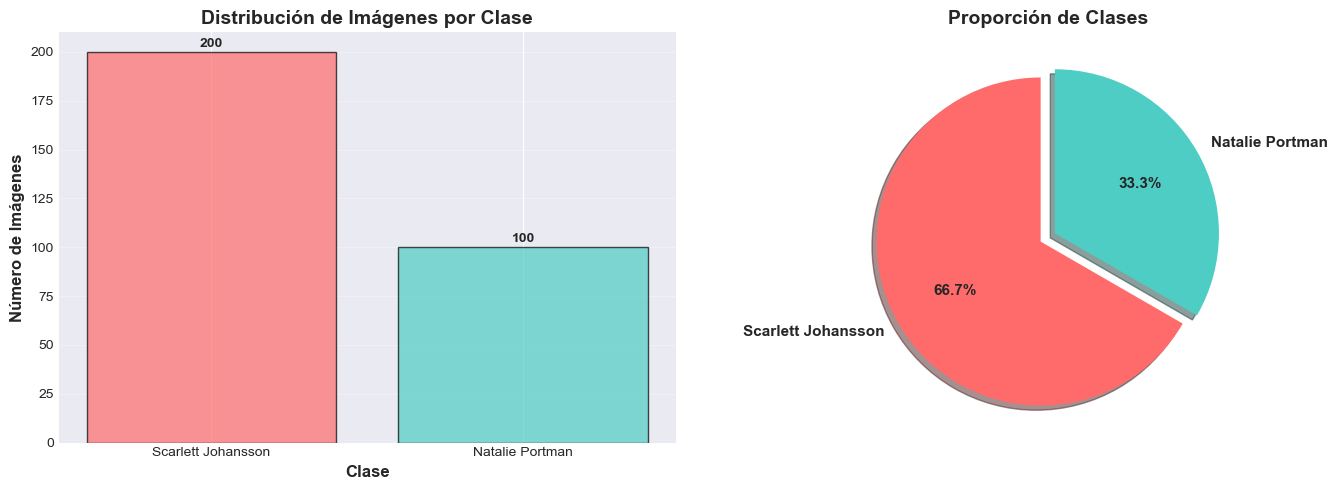

In [4]:
# Distribución por clase
class_distribution = df_info['labels'].value_counts()

print("="*60)
print("DISTRIBUCIÓN DE IMÁGENES POR CLASE")
print("="*60)
for class_name, count in class_distribution.items():
    percentage = (count / len(df_info)) * 100
    print(f"{class_name:20s}: {count:3d} imágenes ({percentage:.1f}%)")
print(f"{'Total':20s}: {len(df_info):3d} imágenes")
print("="*60)

# Calcular balance ratio
balance_ratio = min(class_distribution) / max(class_distribution)
print(f"\n Balance Ratio: {balance_ratio:.2f}")
if balance_ratio >= 0.9:
    print(" Dataset bien balanceado")
elif balance_ratio >= 0.7:
    print(" Dataset moderadamente desbalanceado")
else:
    print(" Dataset significativamente desbalanceado")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(class_distribution.index, class_distribution.values, 
            color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Clase', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Imágenes', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Imágenes por Clase', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (idx, val) in enumerate(class_distribution.items()):
    axes[0].text(i, val + 1, str(val), ha='center', va='bottom', fontweight='bold')

# Gráfico de torta
colors = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)
axes[1].pie(class_distribution.values, labels=class_distribution.index, 
            autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,
            shadow=True, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

"""
### 1.2 Análisis de Formatos, Tamaños y Resoluciones

**Aspectos importantes:**
- **Formato de archivo**: JPG es común para fotografías (compresión con pérdida)
- **Tamaños variables**: Requiere redimensionamiento para redes neuronales
- **Resolución**: Mayor resolución = más detalles, pero mayor costo computacional
- **Canales de color**: RGB (3 canales) es estándar para imágenes a color
"""


ANÁLISIS DE FORMATOS DE IMAGEN
JPEG      : 300 imágenes (100.0%)

ANÁLISIS DE CANALES DE COLOR
RGB                 : 300 imágenes (100.0%)

ESTADÍSTICAS DE RESOLUCIÓN
Ancho promedio:    452 px (±80)
Alto promedio:     510 px (±107)
Megapíxeles medio: 0.24 MP

Resolución mínima:   160x135
Resolución máxima:   474x592
Aspect ratio medio:  0.90


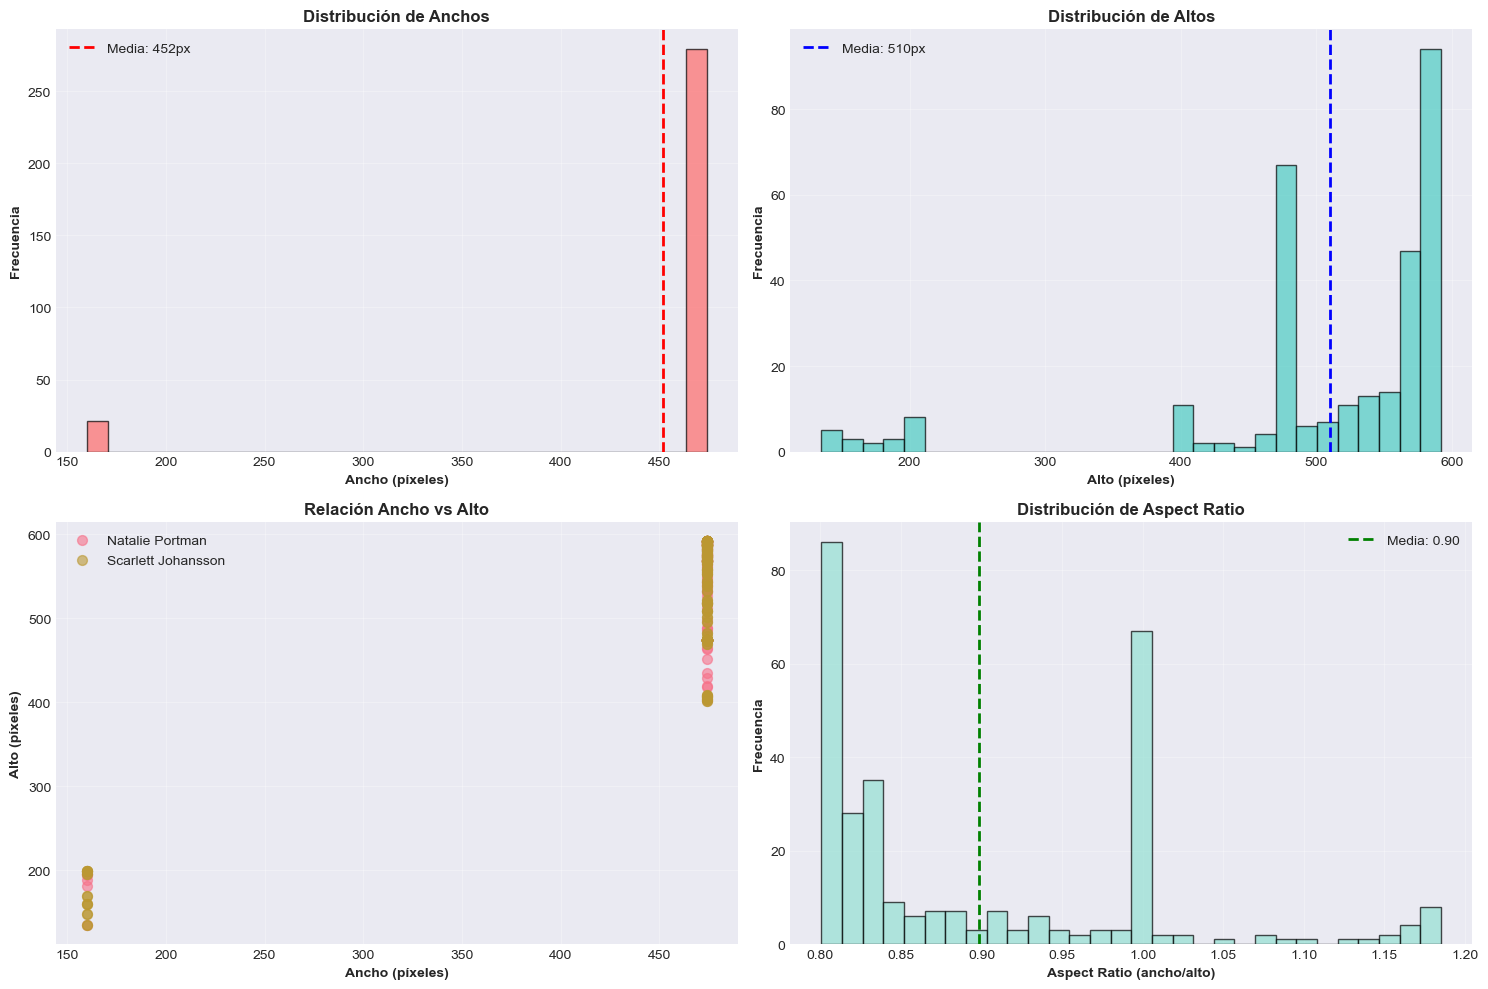

In [5]:
# Análisis de formatos
print("\n" + "="*60)
print("ANÁLISIS DE FORMATOS DE IMAGEN")
print("="*60)
format_counts = df_info['formats'].value_counts()
for fmt, count in format_counts.items():
    percentage = (count / len(df_info)) * 100
    print(f"{fmt:10s}: {count:3d} imágenes ({percentage:.1f}%)")

# Análisis de canales
print("\n" + "="*60)
print("ANÁLISIS DE CANALES DE COLOR")
print("="*60)
channel_counts = df_info['channels'].value_counts()
for ch, count in channel_counts.items():
    ch_name = {1: 'Escala de grises', 3: 'RGB', 4: 'RGBA'}.get(ch, f'{ch} canales')
    percentage = (count / len(df_info)) * 100
    print(f"{ch_name:20s}: {count:3d} imágenes ({percentage:.1f}%)")

# Análisis de resoluciones
df_info['width'] = df_info['sizes'].apply(lambda x: x[0] if x else None)
df_info['height'] = df_info['sizes'].apply(lambda x: x[1] if x else None)
df_info['aspect_ratio'] = df_info['width'] / df_info['height']
df_info['megapixels'] = (df_info['width'] * df_info['height']) / 1e6

print("\n" + "="*60)
print("ESTADÍSTICAS DE RESOLUCIÓN")
print("="*60)
print(f"Ancho promedio:    {df_info['width'].mean():.0f} px (±{df_info['width'].std():.0f})")
print(f"Alto promedio:     {df_info['height'].mean():.0f} px (±{df_info['height'].std():.0f})")
print(f"Megapíxeles medio: {df_info['megapixels'].mean():.2f} MP")
print(f"\nResolución mínima:   {df_info['width'].min():.0f}x{df_info['height'].min():.0f}")
print(f"Resolución máxima:   {df_info['width'].max():.0f}x{df_info['height'].max():.0f}")
print(f"Aspect ratio medio:  {df_info['aspect_ratio'].mean():.2f}")

# Visualización de distribuciones de tamaño
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de anchos
axes[0, 0].hist(df_info['width'], bins=30, color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_info['width'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Media: {df_info["width"].mean():.0f}px')
axes[0, 0].set_xlabel('Ancho (píxeles)', fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontweight='bold')
axes[0, 0].set_title('Distribución de Anchos', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Distribución de altos
axes[0, 1].hist(df_info['height'], bins=30, color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_info['height'].mean(), color='blue', linestyle='--', 
                   linewidth=2, label=f'Media: {df_info["height"].mean():.0f}px')
axes[0, 1].set_xlabel('Alto (píxeles)', fontweight='bold')
axes[0, 1].set_ylabel('Frecuencia', fontweight='bold')
axes[0, 1].set_title('Distribución de Altos', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Scatter plot ancho vs alto
for label in CLASSES:
    mask = df_info['labels'] == label
    axes[1, 0].scatter(df_info[mask]['width'], df_info[mask]['height'], 
                       alpha=0.6, s=50, label=label)
axes[1, 0].set_xlabel('Ancho (píxeles)', fontweight='bold')
axes[1, 0].set_ylabel('Alto (píxeles)', fontweight='bold')
axes[1, 0].set_title('Relación Ancho vs Alto', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Distribución aspect ratio
axes[1, 1].hist(df_info['aspect_ratio'], bins=30, color='#95E1D3', 
                alpha=0.7, edgecolor='black')
axes[1, 1].axvline(df_info['aspect_ratio'].mean(), color='green', 
                   linestyle='--', linewidth=2, 
                   label=f'Media: {df_info["aspect_ratio"].mean():.2f}')
axes[1, 1].set_xlabel('Aspect Ratio (ancho/alto)', fontweight='bold')
axes[1, 1].set_ylabel('Frecuencia', fontweight='bold')
axes[1, 1].set_title('Distribución de Aspect Ratio', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

"""
### 1.3 Detección de Imágenes Corruptas o Problemáticas

**Problemas comunes:**
- **Archivos corruptos**: No se pueden abrir correctamente
- **Imágenes vacías**: Tamaño 0 bytes
- **Formato incorrecto**: Extensión no coincide con contenido real
- **Resolución extrema**: Demasiado pequeñas o grandes

Este análisis previene errores durante el entrenamiento.
"""

In [6]:

print("\n" + "="*60)
print("ANÁLISIS DE INTEGRIDAD DE IMÁGENES")
print("="*60)

corrupted_images = []
empty_images = []
problematic_images = []

for idx, row in df_info.iterrows():
    try:
        # Verificar tamaño de archivo
        file_size = os.path.getsize(row['paths'])
        
        if file_size == 0:
            empty_images.append(row['paths'])
            continue
        
        # Intentar abrir y verificar la imagen
        with Image.open(row['paths']) as img:
            img.verify()  # Verificar integridad
            
        # Reabrir para operaciones adicionales (verify() cierra el archivo)
        with Image.open(row['paths']) as img:
            img.load()  # Forzar carga de datos
            
            # Verificar resoluciones extremas
            if img.size[0] < 50 or img.size[1] < 50:
                problematic_images.append({
                    'path': row['paths'],
                    'issue': f'Resolución muy baja: {img.size}'
                })
            elif img.size[0] > 5000 or img.size[1] > 5000:
                problematic_images.append({
                    'path': row['paths'],
                    'issue': f'Resolución muy alta: {img.size}'
                })
                
    except Exception as e:
        corrupted_images.append({
            'path': row['paths'],
            'error': str(e)
        })

print(f" Imágenes analizadas: {len(df_info)}")
print(f" Imágenes válidas: {len(df_info) - len(corrupted_images) - len(empty_images)}")
print(f" Imágenes corruptas: {len(corrupted_images)}")
print(f" Imágenes vacías: {len(empty_images)}")
print(f" Imágenes problemáticas: {len(problematic_images)}")

if corrupted_images:
    print("\n IMÁGENES CORRUPTAS DETECTADAS:")
    for img in corrupted_images[:5]:  # Mostrar solo las primeras 5
        print(f"  - {os.path.basename(img['path'])}: {img['error']}")
    if len(corrupted_images) > 5:
        print(f"  ... y {len(corrupted_images) - 5} más")

if problematic_images:
    print("\n IMÁGENES PROBLEMÁTICAS DETECTADAS:")
    for img in problematic_images[:5]:
        print(f"  - {os.path.basename(img['path'])}: {img['issue']}")
    if len(problematic_images) > 5:
        print(f"  ... y {len(problematic_images) - 5} más")


ANÁLISIS DE INTEGRIDAD DE IMÁGENES
 Imágenes analizadas: 300
 Imágenes válidas: 300
 Imágenes corruptas: 0
 Imágenes vacías: 0
 Imágenes problemáticas: 0


"""
### 1.4 Análisis de Variedad de Condiciones

**Factores que evaluar:**
- **Iluminación**: Brillo promedio de la imagen
- **Contraste**: Diferencia entre píxeles claros y oscuros
- **Nitidez**: Detección de desenfoque (blur)
- **Complejidad**: Variedad de colores y texturas

Un dataset diverso mejora la capacidad de generalización del modelo.
"""


 Analizando muestra de 100 imágenes para evaluar variedad...

ESTADÍSTICAS DE VARIEDAD
Brillo promedio:     119.90 ± 35.09
Contraste promedio:  62.97 ± 11.75
Nitidez promedio:    605.96 ± 781.53
Varianza de color:   64.27 ± 11.01


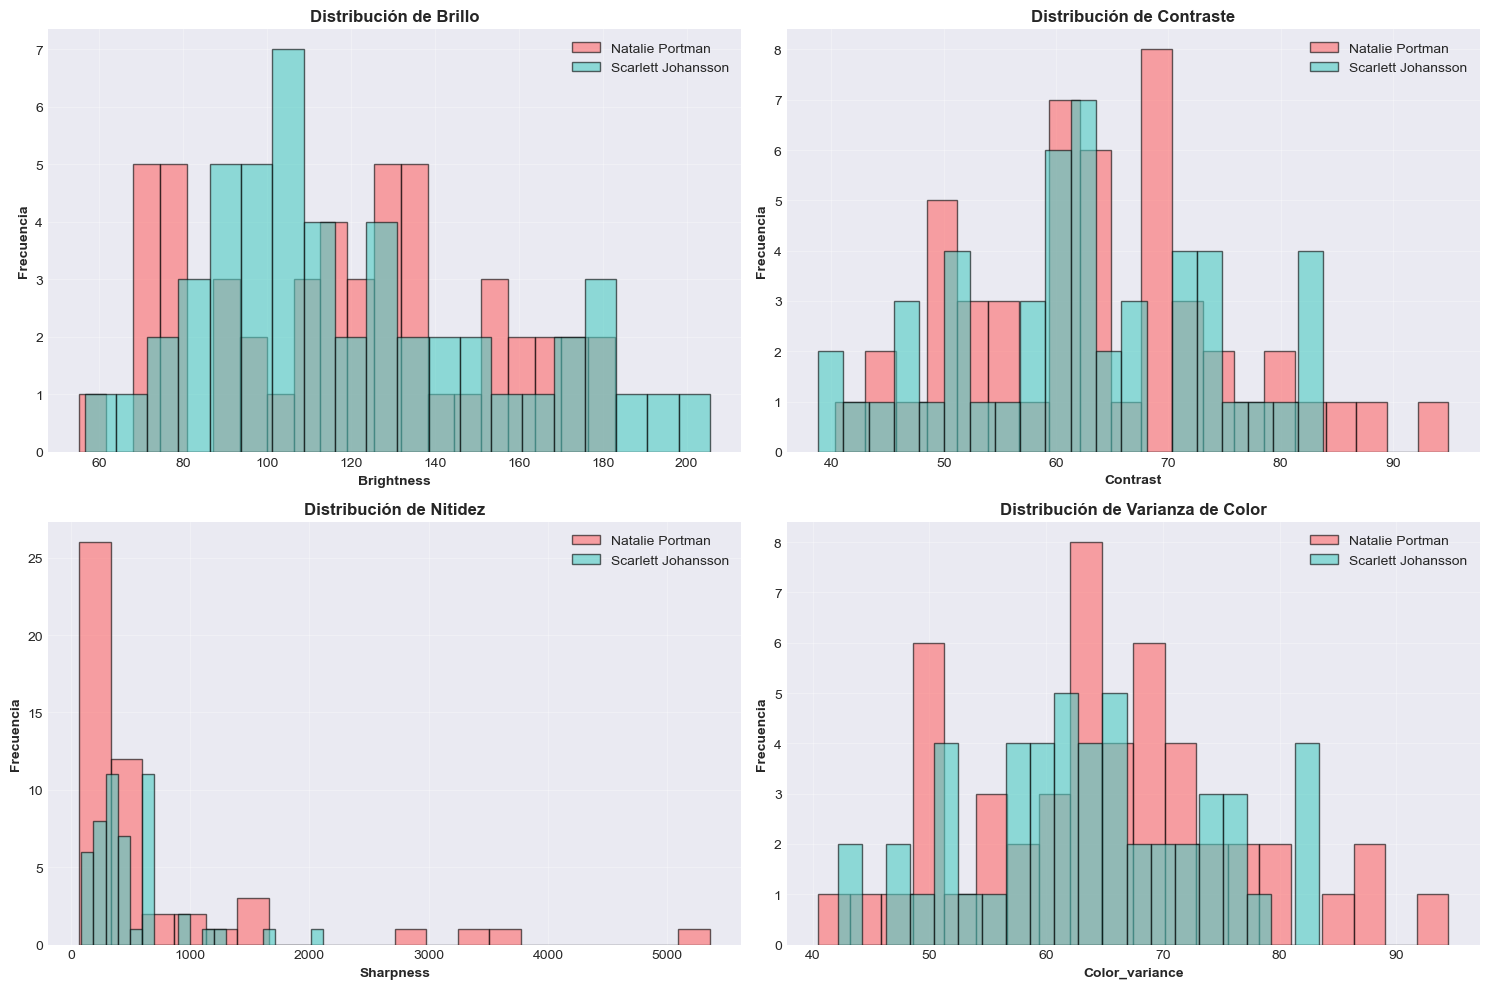


✓ Exploración general completada


In [7]:

# Seleccionar muestra aleatoria para análisis profundo (para no consumir demasiada memoria)
sample_size = min(50, len(df_info) // 2)  # 50 imágenes por clase
df_sample = df_info.groupby('labels').apply(
    lambda x: x.sample(n=min(sample_size, len(x)), random_state=42)
).reset_index(drop=True)

print(f"\n Analizando muestra de {len(df_sample)} imágenes para evaluar variedad...")

# Métricas de variedad
variety_metrics = {
    'brightness': [],
    'contrast': [],
    'sharpness': [],
    'color_variance': [],
    'labels': []
}

for idx, row in df_sample.iterrows():
    try:
        img = cv2.imread(row['paths'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Brillo (promedio de intensidad)
        brightness = np.mean(img_gray)
        
        # Contraste (desviación estándar)
        contrast = np.std(img_gray)
        
        # Nitidez (usando Laplaciano)
        laplacian_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
        
        # Varianza de color
        color_var = np.mean([np.std(img_rgb[:,:,i]) for i in range(3)])
        
        variety_metrics['brightness'].append(brightness)
        variety_metrics['contrast'].append(contrast)
        variety_metrics['sharpness'].append(laplacian_var)
        variety_metrics['color_variance'].append(color_var)
        variety_metrics['labels'].append(row['labels'])
        
    except Exception as e:
        continue

df_variety = pd.DataFrame(variety_metrics)

print("\n" + "="*60)
print("ESTADÍSTICAS DE VARIEDAD")
print("="*60)
print(f"Brillo promedio:     {df_variety['brightness'].mean():.2f} ± {df_variety['brightness'].std():.2f}")
print(f"Contraste promedio:  {df_variety['contrast'].mean():.2f} ± {df_variety['contrast'].std():.2f}")
print(f"Nitidez promedio:    {df_variety['sharpness'].mean():.2f} ± {df_variety['sharpness'].std():.2f}")
print(f"Varianza de color:   {df_variety['color_variance'].mean():.2f} ± {df_variety['color_variance'].std():.2f}")

# Visualización de métricas de variedad
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['brightness', 'contrast', 'sharpness', 'color_variance']
titles = ['Distribución de Brillo', 'Distribución de Contraste', 
          'Distribución de Nitidez', 'Distribución de Varianza de Color']
colors_palette = ['#FF6B6B', '#4ECDC4']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for i, label in enumerate(CLASSES):
        data = df_variety[df_variety['labels'] == label][metric]
        ax.hist(data, bins=20, alpha=0.6, label=label, 
                color=colors_palette[i], edgecolor='black')
    
    ax.set_xlabel(metric.capitalize(), fontweight='bold')
    ax.set_ylabel('Frecuencia', fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Exploración general completada")

"""
## 2. ANÁLISIS ESTADÍSTICO

### 2.1 Media y Desviación Estándar por Canal RGB

**Importancia:**
- **Media**: Indica el tono promedio de las imágenes (oscuro/claro)
- **Desviación estándar**: Mide la variabilidad de intensidad
- **Por canal**: RGB tiene características diferentes (cielo = más azul, piel = más rojo)

**Aplicación:**
Estos valores se usan para **normalización** durante el entrenamiento:
```python
imagen_normalizada = (imagen - media) / desviacion_estandar
```

Esto centra los datos en cero y escala su varianza, mejorando la convergencia.
"""


ANÁLISIS ESTADÍSTICO POR CANAL RGB
Calculando estadísticas RGB...

 ESTADÍSTICAS GLOBALES (rango 0-255):
----------------------------------------------------------------------
Canal ROJO   - Media: 135.86 ± 70.14
Canal VERDE  - Media: 114.82 ± 62.28
Canal AZUL   - Media: 104.20 ± 60.39

Rango de valores:
  Mínimo: 0
  Máximo: 255

 ESTADÍSTICAS POR CLASE:
----------------------------------------------------------------------

Natalie Portman:
  R: 135.68 ± 69.78
  G: 113.84 ± 63.50
  B: 102.34 ± 61.02

Scarlett Johansson:
  R: 136.03 ± 70.51
  G: 115.80 ± 61.06
  B: 106.06 ± 59.77

VALORES RECOMENDADOS PARA NORMALIZACIÓN
Mean RGB: ['135.86', '114.82', '104.20']
Std RGB:  ['70.14', '62.28', '60.39']

Fórmula de normalización:
img_norm = (img - mean) / std


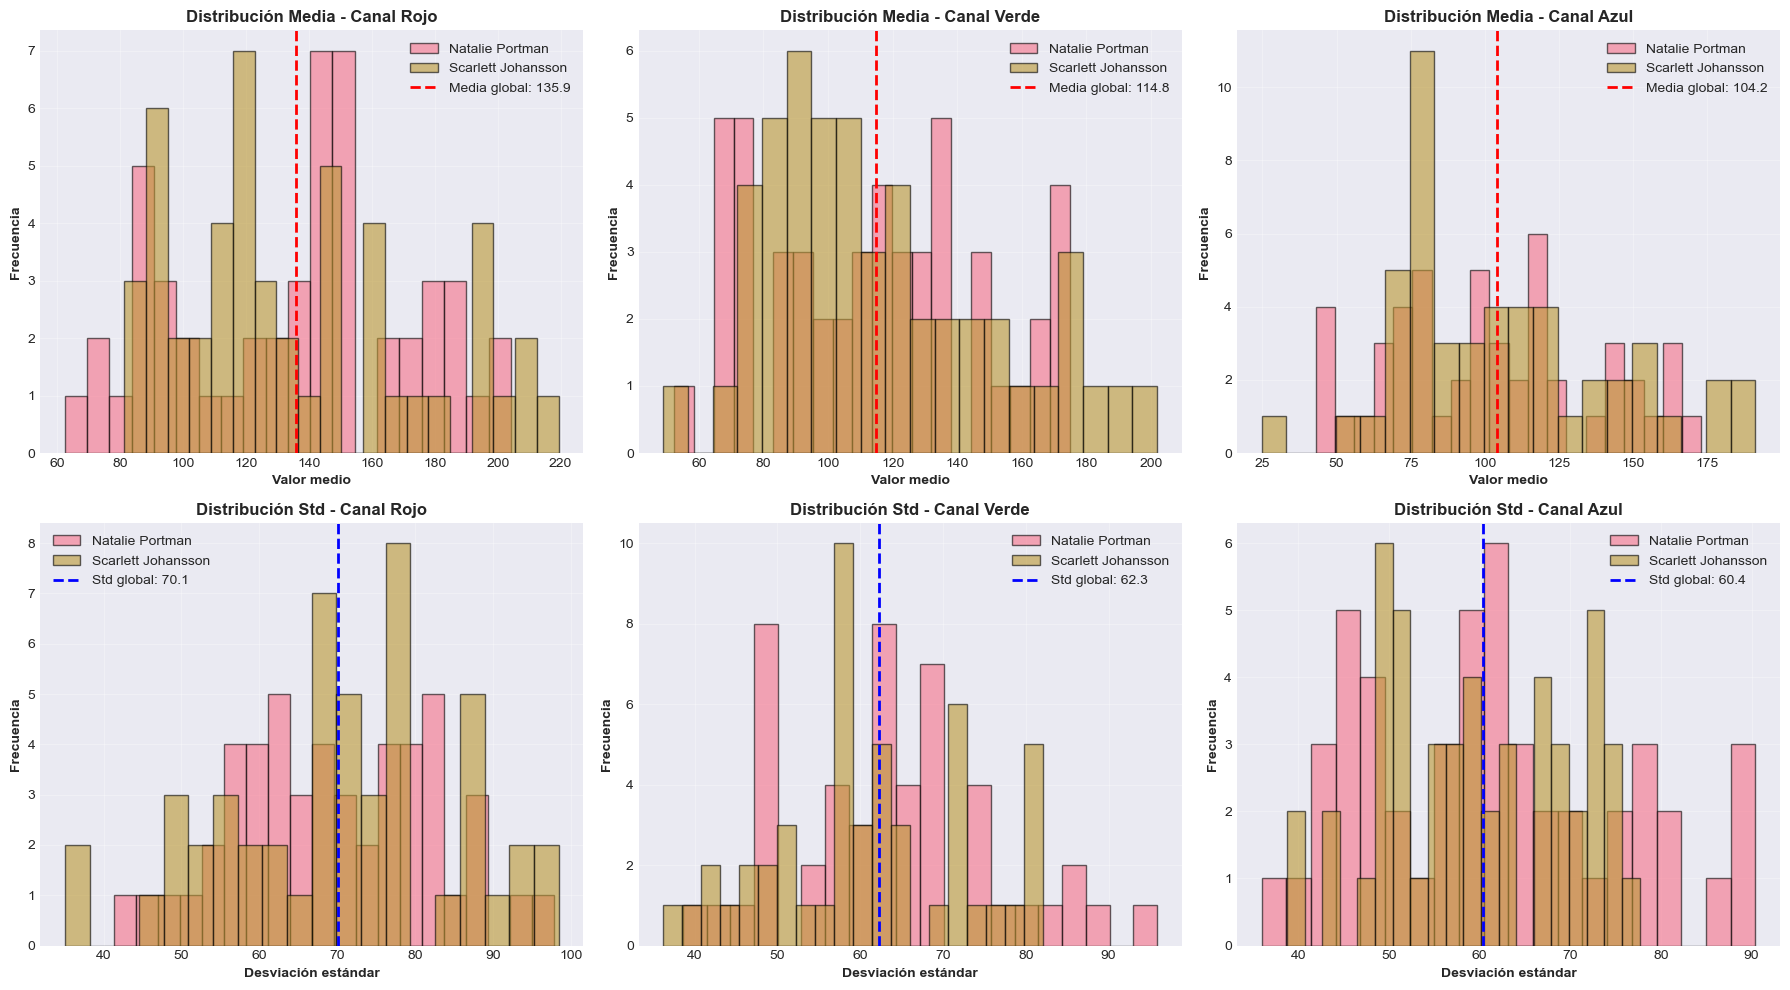

In [8]:

print("\n" + "="*70)
print("ANÁLISIS ESTADÍSTICO POR CANAL RGB")
print("="*70)

# Cargar muestra de imágenes para análisis estadístico
rgb_stats = {
    'mean_r': [], 'mean_g': [], 'mean_b': [],
    'std_r': [], 'std_g': [], 'std_b': [],
    'min_val': [], 'max_val': [],
    'labels': []
}

print("Calculando estadísticas RGB...")
for idx, row in df_sample.iterrows():
    try:
        img = cv2.imread(row['paths'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Estadísticas por canal
        rgb_stats['mean_r'].append(np.mean(img_rgb[:,:,0]))
        rgb_stats['mean_g'].append(np.mean(img_rgb[:,:,1]))
        rgb_stats['mean_b'].append(np.mean(img_rgb[:,:,2]))
        
        rgb_stats['std_r'].append(np.std(img_rgb[:,:,0]))
        rgb_stats['std_g'].append(np.std(img_rgb[:,:,1]))
        rgb_stats['std_b'].append(np.std(img_rgb[:,:,2]))
        
        rgb_stats['min_val'].append(np.min(img_rgb))
        rgb_stats['max_val'].append(np.max(img_rgb))
        rgb_stats['labels'].append(row['labels'])
        
    except Exception as e:
        continue

df_rgb_stats = pd.DataFrame(rgb_stats)

# Estadísticas globales
print("\n ESTADÍSTICAS GLOBALES (rango 0-255):")
print("-" * 70)
print(f"Canal ROJO   - Media: {df_rgb_stats['mean_r'].mean():.2f} ± {df_rgb_stats['std_r'].mean():.2f}")
print(f"Canal VERDE  - Media: {df_rgb_stats['mean_g'].mean():.2f} ± {df_rgb_stats['std_g'].mean():.2f}")
print(f"Canal AZUL   - Media: {df_rgb_stats['mean_b'].mean():.2f} ± {df_rgb_stats['std_b'].mean():.2f}")
print(f"\nRango de valores:")
print(f"  Mínimo: {df_rgb_stats['min_val'].min()}")
print(f"  Máximo: {df_rgb_stats['max_val'].max()}")

# Estadísticas por clase
print("\n ESTADÍSTICAS POR CLASE:")
print("-" * 70)
for label in CLASSES:
    df_class = df_rgb_stats[df_rgb_stats['labels'] == label]
    print(f"\n{label}:")
    print(f"  R: {df_class['mean_r'].mean():.2f} ± {df_class['std_r'].mean():.2f}")
    print(f"  G: {df_class['mean_g'].mean():.2f} ± {df_class['std_g'].mean():.2f}")
    print(f"  B: {df_class['mean_b'].mean():.2f} ± {df_class['std_b'].mean():.2f}")

# Valores para normalización
global_mean = [df_rgb_stats['mean_r'].mean(), 
               df_rgb_stats['mean_g'].mean(), 
               df_rgb_stats['mean_b'].mean()]
global_std = [df_rgb_stats['std_r'].mean(), 
              df_rgb_stats['std_g'].mean(), 
              df_rgb_stats['std_b'].mean()]

print("\n" + "="*70)
print("VALORES RECOMENDADOS PARA NORMALIZACIÓN")
print("="*70)
print(f"Mean RGB: {[f'{m:.2f}' for m in global_mean]}")
print(f"Std RGB:  {[f'{s:.2f}' for s in global_std]}")
print("\nFórmula de normalización:")
print("img_norm = (img - mean) / std")
print("="*70)

# Visualización de distribuciones RGB
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

channels = ['mean_r', 'mean_g', 'mean_b']
channel_names = ['Canal Rojo', 'Canal Verde', 'Canal Azul']
channel_colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

# Primera fila: Medias
for idx, (channel, name, color) in enumerate(zip(channels, channel_names, channel_colors)):
    for i, label in enumerate(CLASSES):
        data = df_rgb_stats[df_rgb_stats['labels'] == label][channel]
        axes[0, idx].hist(data, bins=20, alpha=0.6, label=label, edgecolor='black')
    
    axes[0, idx].axvline(df_rgb_stats[channel].mean(), color='red', 
                         linestyle='--', linewidth=2, 
                         label=f'Media global: {df_rgb_stats[channel].mean():.1f}')
    axes[0, idx].set_xlabel('Valor medio', fontweight='bold')
    axes[0, idx].set_ylabel('Frecuencia', fontweight='bold')
    axes[0, idx].set_title(f'Distribución Media - {name}', fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

# Segunda fila: Desviaciones estándar
std_channels = ['std_r', 'std_g', 'std_b']
for idx, (channel, name, color) in enumerate(zip(std_channels, channel_names, channel_colors)):
    for i, label in enumerate(CLASSES):
        data = df_rgb_stats[df_rgb_stats['labels'] == label][channel]
        axes[1, idx].hist(data, bins=20, alpha=0.6, label=label, edgecolor='black')
    
    axes[1, idx].axvline(df_rgb_stats[channel].mean(), color='blue', 
                         linestyle='--', linewidth=2, 
                         label=f'Std global: {df_rgb_stats[channel].mean():.1f}')
    axes[1, idx].set_xlabel('Desviación estándar', fontweight='bold')
    axes[1, idx].set_ylabel('Frecuencia', fontweight='bold')
    axes[1, idx].set_title(f'Distribución Std - {name}', fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

"""
### 2.2 Detección de Valores Atípicos)

**Criterios para detectar outliers:**
1. **Imágenes extremadamente oscuras**: Mean < 50
2. **Imágenes extremadamente claras**: Mean > 200
3. **Bajo contraste**: Std < 20 (imagen muy uniforme)
4. **Desenfocadas**: Laplacian variance < umbral

Estos outliers pueden:
- Confundir al modelo durante entrenamiento
- Indicar etiquetas incorrectas
- Señalar problemas de calidad en la captura
"""

In [9]:

print("\n" + "="*70)
print("DETECCIÓN DE VALORES ATÍPICOS (OUTLIERS)")
print("="*70)

outliers = {
    'muy_oscuras': [],
    'muy_claras': [],
    'bajo_contraste': [],
    'desenfocadas': []
}

# Calcular media global de brillo
overall_mean = (df_rgb_stats['mean_r'].mean() + 
                df_rgb_stats['mean_g'].mean() + 
                df_rgb_stats['mean_b'].mean()) / 3

# Detectar outliers
for idx, row in df_sample.iterrows():
    try:
        img = cv2.imread(row['paths'])
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        mean_brightness = np.mean(img_gray)
        std_contrast = np.std(img_gray)
        sharpness = cv2.Laplacian(img_gray, cv2.CV_64F).var()
        
        # Criterios de detección
        if mean_brightness < 50:
            outliers['muy_oscuras'].append({
                'path': row['paths'],
                'brightness': mean_brightness,
                'label': row['labels']
            })
        
        if mean_brightness > 200:
            outliers['muy_claras'].append({
                'path': row['paths'],
                'brightness': mean_brightness,
                'label': row['labels']
            })
        
        if std_contrast < 20:
            outliers['bajo_contraste'].append({
                'path': row['paths'],
                'contrast': std_contrast,
                'label': row['labels']
            })
        
        if sharpness < 100:
            outliers['desenfocadas'].append({
                'path': row['paths'],
                'sharpness': sharpness,
                'label': row['labels']
            })
            
    except Exception as e:
        continue

# Reporte de outliers
print(f"\n RESUMEN DE OUTLIERS DETECTADOS:")
print(f"  Imágenes muy oscuras (< 50):    {len(outliers['muy_oscuras'])}")
print(f"  Imágenes muy claras (> 200):    {len(outliers['muy_claras'])}")
print(f"  Imágenes bajo contraste (< 20): {len(outliers['bajo_contraste'])}")
print(f"  Imágenes desenfocadas (< 100):  {len(outliers['desenfocadas'])}")

total_outliers = sum(len(v) for v in outliers.values())
outlier_percentage = (total_outliers / len(df_sample)) * 100
print(f"\n Total de outliers: {total_outliers} ({outlier_percentage:.1f}% de la muestra)")

# Mostrar ejemplos de outliers detectados
if any(len(v) > 0 for v in outliers.values()):
    print("\n EJEMPLOS DE OUTLIERS:")
    for category, items in outliers.items():
        if items:
            print(f"\n{category.upper().replace('_', ' ')}:")
            for item in items[:3]:  # Mostrar solo 3 ejemplos
                filename = os.path.basename(item['path'])
                metric_key = [k for k in item.keys() if k not in ['path', 'label']][0]
                print(f"  - {filename} [{item['label']}]: {metric_key}={item[metric_key]:.2f}")



DETECCIÓN DE VALORES ATÍPICOS (OUTLIERS)

 RESUMEN DE OUTLIERS DETECTADOS:
  Imágenes muy oscuras (< 50):    0
  Imágenes muy claras (> 200):    1
  Imágenes bajo contraste (< 20): 0
  Imágenes desenfocadas (< 100):  3

 Total de outliers: 4 (4.0% de la muestra)

 EJEMPLOS DE OUTLIERS:

MUY CLARAS:
  - 153_e68fb09b.jpg [Scarlett Johansson]: brightness=205.54

DESENFOCADAS:
  - 045_2538be49.jpg [Natalie Portman]: sharpness=94.82
  - 066_6d963e5e.jpg [Natalie Portman]: sharpness=70.95
  - 136_2b8c824e.jpg [Scarlett Johansson]: sharpness=87.08


"""
## 3. PREPROCESAMIENTO BÁSICO

### Objetivos del Preprocesamiento:
1. **Redimensionamiento**: Todas las imágenes al mismo tamaño
2. **Normalización**: Escalar valores de píxeles
3. **Conversión de color**: Asegurar formato RGB consistente

### Tamaños comunes para CNNs:
- **224x224**: VGG, ResNet (estándar)
- **299x299**: Inception
- **128x128, 256x256**: Balance entre calidad y cómputo

Elegiremos **224x224** por ser el estándar más utilizado.
"""


DEMOSTRACIÓN DE PREPROCESAMIENTO
Tamaño objetivo: (224, 224)
Media para normalización: [0.532769   0.45025723 0.40862569]
Std para normalización: [0.27507428 0.244239   0.23683066]

 Visualizando pasos de preprocesamiento...

Clase: Natalie Portman


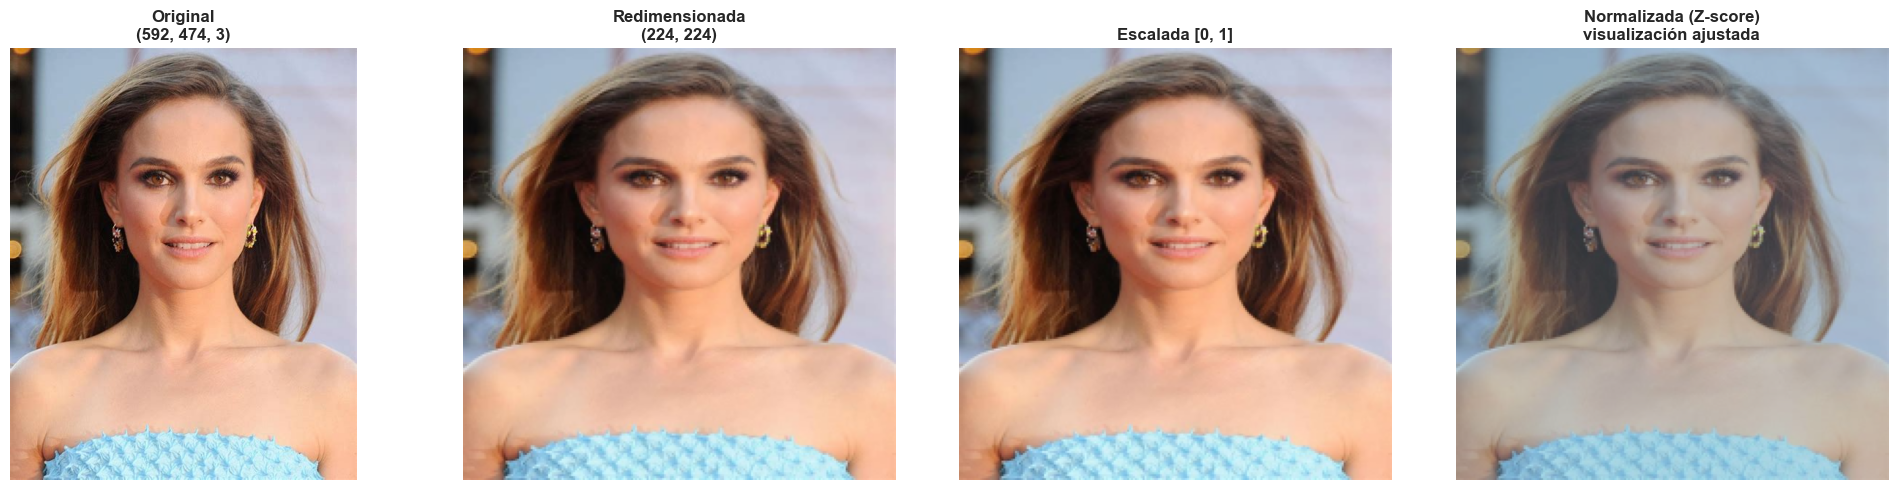


Clase: Scarlett Johansson


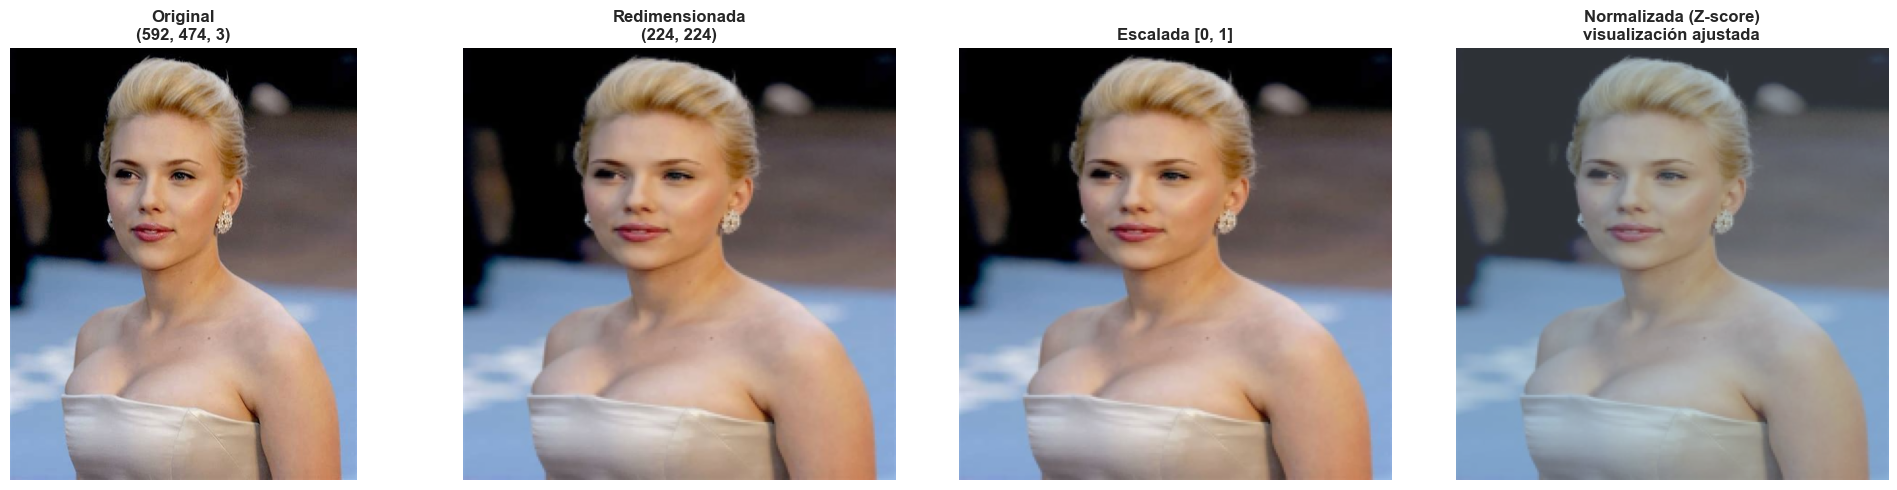

In [10]:

# Configuración de preprocesamiento
TARGET_SIZE = (224, 224)
NORMALIZE_MEAN = np.array(global_mean) / 255.0  # Convertir a rango [0,1]
NORMALIZE_STD = np.array(global_std) / 255.0

def preprocess_image(image_path, target_size=TARGET_SIZE, normalize=True):
    """
    Preprocesa una imagen para entrenamiento de CNN
    
    Args:
        image_path: Ruta a la imagen
        target_size: Tupla (altura, ancho) para redimensionar
        normalize: Si True, aplica normalización Z-score
    
    Returns:
        Imagen preprocesada como array numpy
    """
    try:
        # Cargar imagen
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Redimensionar
        img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
        
        # Convertir a float y escalar a [0, 1]
        img_float = img_resized.astype(np.float32) / 255.0
        
        # Normalizar (Z-score)
        if normalize:
            img_normalized = (img_float - NORMALIZE_MEAN) / NORMALIZE_STD
            return img_normalized
        
        return img_float
        
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

def visualize_preprocessing_steps(image_path):
    """
    Visualiza los pasos del preprocesamiento
    """
    # Original
    img_original = cv2.imread(image_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    
    # Redimensionada
    img_resized = cv2.resize(img_original, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    
    # Normalizada (escala [0,1])
    img_scaled = img_resized.astype(np.float32) / 255.0
    
    # Normalizada (Z-score) - visualización ajustada
    img_normalized = (img_scaled - NORMALIZE_MEAN) / NORMALIZE_STD
    # Ajustar para visualización (clip y reescalar)
    img_norm_vis = np.clip(img_normalized, -3, 3)
    img_norm_vis = (img_norm_vis + 3) / 6  # Reescalar a [0,1]
    
    # Visualizar
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(img_original)
    axes[0].set_title(f'Original\n{img_original.shape}', fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img_resized)
    axes[1].set_title(f'Redimensionada\n{TARGET_SIZE}', fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(img_scaled)
    axes[2].set_title('Escalada [0, 1]', fontweight='bold')
    axes[2].axis('off')
    
    axes[3].imshow(img_norm_vis)
    axes[3].set_title('Normalizada (Z-score)\nvisualización ajustada', fontweight='bold')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Demostración de preprocesamiento
print("\n" + "="*70)
print("DEMOSTRACIÓN DE PREPROCESAMIENTO")
print("="*70)
print(f"Tamaño objetivo: {TARGET_SIZE}")
print(f"Media para normalización: {NORMALIZE_MEAN}")
print(f"Std para normalización: {NORMALIZE_STD}")

# Seleccionar una imagen de cada clase para demostración
sample_images = df_info.groupby('labels').apply(lambda x: x.sample(1)).reset_index(drop=True)

print("\n Visualizando pasos de preprocesamiento...")
for idx, row in sample_images.iterrows():
    print(f"\nClase: {row['labels']}")
    visualize_preprocessing_steps(row['paths'])

"""
## 4. AUMENTO DE DATOS (DATA AUGMENTATION)

### ¿Por qué es importante?
- **Previene sobreajuste**: El modelo aprende características más generales
- **Aumenta tamaño del dataset**: Efectivamente multiplica tus datos
- **Mejora generalización**: El modelo se vuelve más robusto

### Transformaciones comunes:
1. **Geométricas**: Rotación, flip horizontal, zoom, traslación
2. **Color**: Ajustes de brillo, contraste, saturación
3. **Ruido**: Añadir ruido gaussiano
4. **Oclusión**: Simular objetos que tapan parcialmente

⚠️ **Importante**: Algunas transformaciones no son apropiadas para rostros:
-  Flip vertical (los rostros no aparecen al revés)
-  Rotaciones extremas (>30°)
-  Flip horizontal (selfie vs foto normal)
-  Pequeñas rotaciones (cabeza ligeramente inclinada)
-  Cambios de brillo/contraste (diferentes iluminaciones)
"""




DEMOSTRACIÓN DE AUMENTO DE DATOS

Imagen de demostración: 144_99c39c61.jpg
Generando 8 variaciones aumentadas...


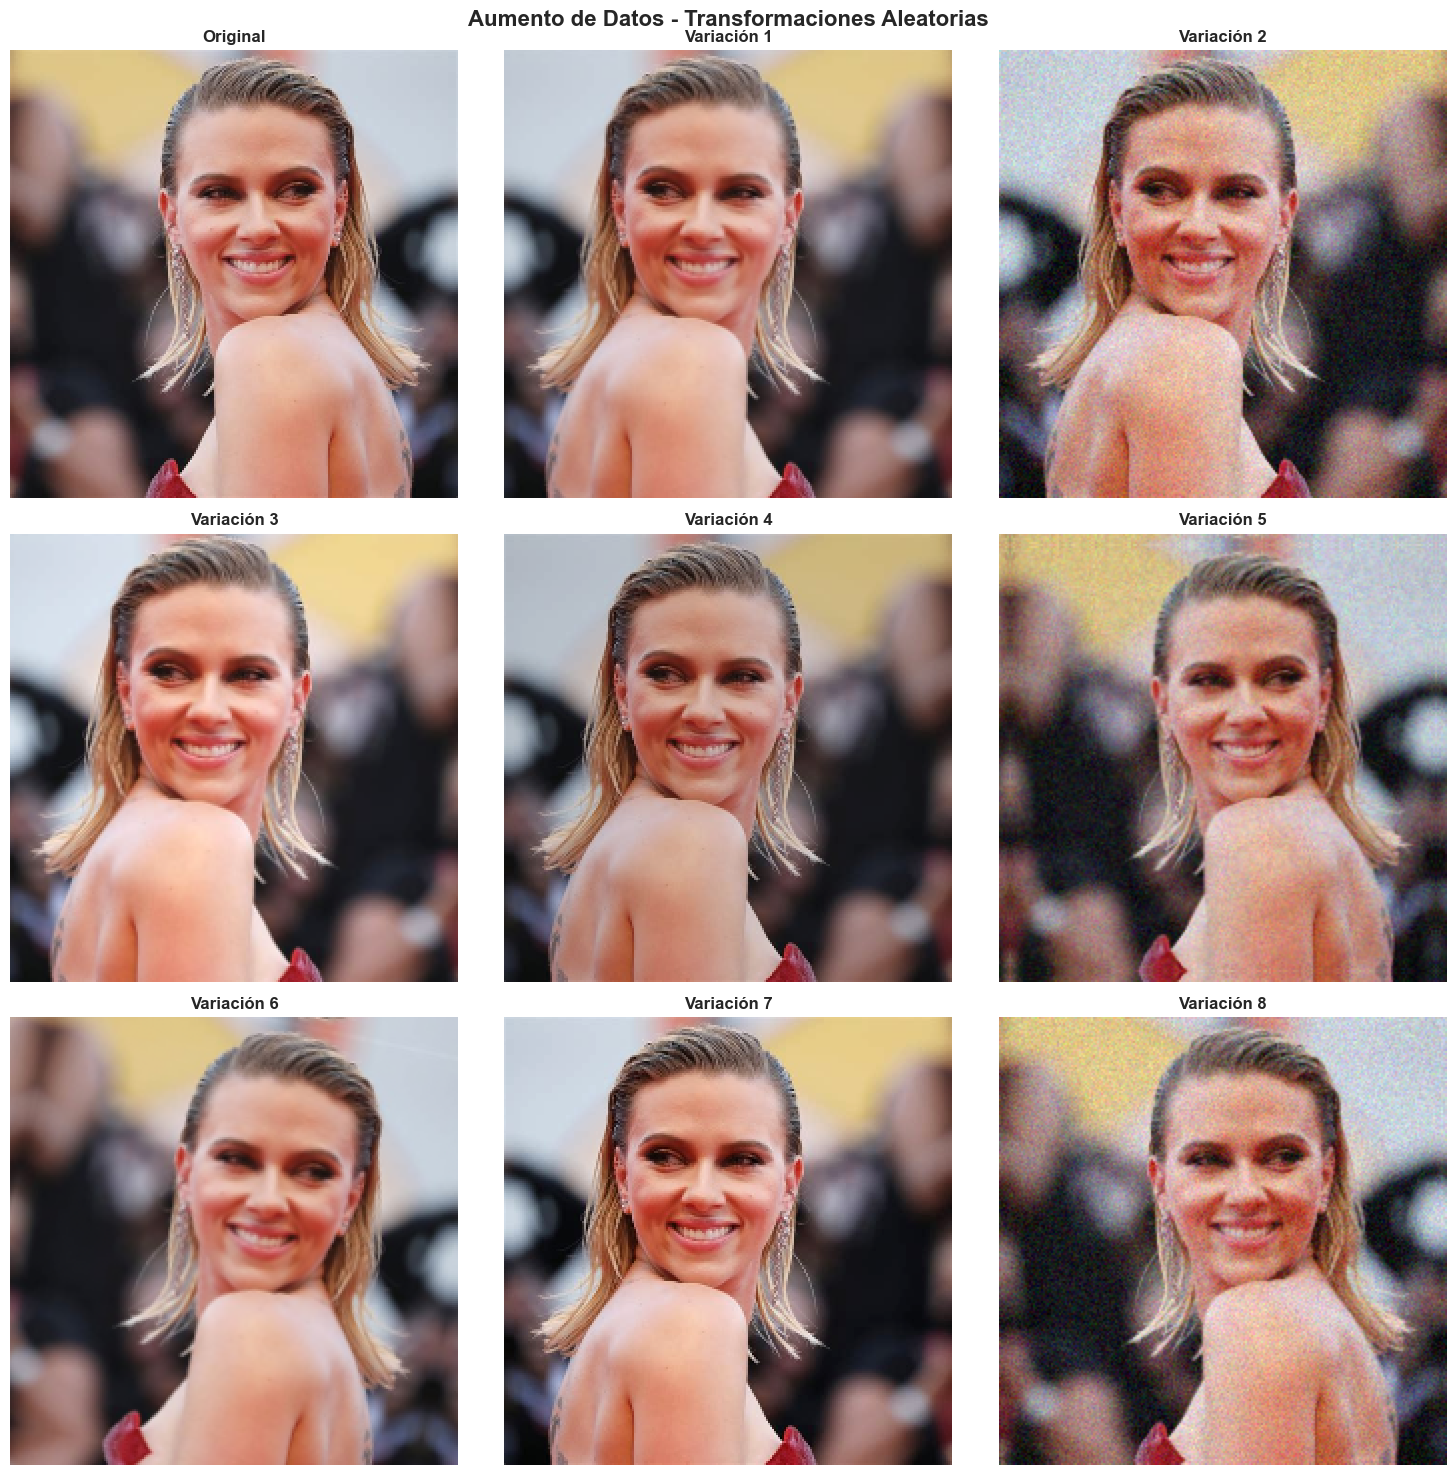


 Con el aumento de datos, cada imagen puede generar múltiples variaciones
 Esto multiplica efectivamente el tamaño de tu dataset de entrenamiento

 Preprocesamiento y aumento de datos completados


In [11]:

class ImageAugmentor:
    """
    Clase para aplicar aumentaciones de datos a imágenes
    """
    
    @staticmethod
    def horizontal_flip(image):
        """Voltear horizontalmente"""
        return np.fliplr(image)
    
    @staticmethod
    def rotate(image, angle_range=(-15, 15)):
        """Rotar imagen aleatoriamente"""
        angle = np.random.uniform(angle_range[0], angle_range[1])
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        
        # Matriz de rotación
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), 
                                 borderMode=cv2.BORDER_REFLECT)
        return rotated
    
    @staticmethod
    def adjust_brightness(image, factor_range=(0.7, 1.3)):
        """Ajustar brillo"""
        factor = np.random.uniform(factor_range[0], factor_range[1])
        adjusted = np.clip(image * factor, 0, 1)
        return adjusted
    
    @staticmethod
    def adjust_contrast(image, factor_range=(0.8, 1.2)):
        """Ajustar contraste"""
        factor = np.random.uniform(factor_range[0], factor_range[1])
        mean = np.mean(image)
        adjusted = np.clip((image - mean) * factor + mean, 0, 1)
        return adjusted
    
    @staticmethod
    def add_noise(image, noise_factor=0.05):
        """Añadir ruido gaussiano"""
        noise = np.random.normal(0, noise_factor, image.shape)
        noisy = np.clip(image + noise, 0, 1)
        return noisy
    
    @staticmethod
    def random_zoom(image, zoom_range=(0.9, 1.1)):
        """Zoom aleatorio"""
        zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
        h, w = image.shape[:2]
        
        # Calcular nuevo tamaño
        new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
        
        # Redimensionar
        resized = cv2.resize(image, (new_w, new_h))
        
        # Crop o pad para volver al tamaño original
        if zoom_factor > 1:  # Zoom in - crop
            start_h = (new_h - h) // 2
            start_w = (new_w - w) // 2
            cropped = resized[start_h:start_h+h, start_w:start_w+w]
            return cropped
        else:  # Zoom out - pad
            pad_h = (h - new_h) // 2
            pad_w = (w - new_w) // 2
            padded = np.pad(resized, 
                          ((pad_h, h-new_h-pad_h), (pad_w, w-new_w-pad_w), (0,0)),
                          mode='reflect')
            return padded
    
    @staticmethod
    def augment_image(image, num_augmentations=5):
        """
        Aplica múltiples aumentaciones aleatorias
        
        Args:
            image: Imagen en formato numpy array (valores [0, 1])
            num_augmentations: Número de transformaciones a aplicar
        
        Returns:
            Lista de imágenes aumentadas
        """
        augmentations = [
            ImageAugmentor.horizontal_flip,
            ImageAugmentor.rotate,
            ImageAugmentor.adjust_brightness,
            ImageAugmentor.adjust_contrast,
            ImageAugmentor.add_noise,
            ImageAugmentor.random_zoom
        ]
        
        augmented_images = []
        
        for _ in range(num_augmentations):
            # Copiar imagen original
            img_aug = image.copy()
            
            # Aplicar 2-3 transformaciones aleatorias
            num_transforms = np.random.randint(2, 4)
            selected_augs = np.random.choice(augmentations, num_transforms, replace=False)
            
            for aug_func in selected_augs:
                img_aug = aug_func(img_aug)
            
            augmented_images.append(img_aug)
        
        return augmented_images

# Demostración de aumentaciones
print("\n" + "="*70)
print("DEMOSTRACIÓN DE AUMENTO DE DATOS")
print("="*70)

# Seleccionar una imagen para demostrar
demo_path = df_info.sample(1).iloc[0]['paths']
demo_img = cv2.imread(demo_path)
demo_img = cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB)
demo_img = cv2.resize(demo_img, TARGET_SIZE)
demo_img = demo_img.astype(np.float32) / 255.0

print(f"\nImagen de demostración: {os.path.basename(demo_path)}")
print("Generando 8 variaciones aumentadas...")

# Generar aumentaciones
augmented = ImageAugmentor.augment_image(demo_img, num_augmentations=8)

# Visualizar
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Original
axes[0].imshow(demo_img)
axes[0].set_title('Original', fontweight='bold', fontsize=12)
axes[0].axis('off')

# Aumentaciones
aug_names = ['Variación 1', 'Variación 2', 'Variación 3', 'Variación 4',
             'Variación 5', 'Variación 6', 'Variación 7', 'Variación 8']

for idx, (img, name) in enumerate(zip(augmented, aug_names), 1):
    axes[idx].imshow(np.clip(img, 0, 1))
    axes[idx].set_title(name, fontweight='bold', fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Aumento de Datos - Transformaciones Aleatorias', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n Con el aumento de datos, cada imagen puede generar múltiples variaciones")
print(" Esto multiplica efectivamente el tamaño de tu dataset de entrenamiento")

print("\n Preprocesamiento y aumento de datos completados")

"""
## 5. LIMPIEZA Y CONTROL DE CALIDAD

### Objetivos:
1. **Eliminar duplicados**: Imágenes idénticas o muy similares
2. **Remover imágenes corruptas**: Archivos dañados o ilegibles
3. **Corregir etiquetas**: Verificar que las imágenes estén bien clasificadas
4. **Comprobar integridad**: Todos los archivos son válidos

### Métodos de detección de duplicados:
- **Hash MD5**: Detecta duplicados exactos
- **Perceptual hashing**: Detecta imágenes visualmente similares
- **Histograma de similitud**: Compara distribuciones de color
"""

In [13]:

print("\n" + "="*70)
print("LIMPIEZA Y CONTROL DE CALIDAD")
print("="*70)

def calculate_image_hash(image_path):
    """
    Calcula hash MD5 de una imagen para detectar duplicados exactos
    """
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

def calculate_perceptual_hash(image_path, hash_size=8):
    """
    Calcula hash perceptual para detectar imágenes visualmente similares
    """
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (hash_size + 1, hash_size))
        
        # Calcular diferencias
        diff = img[:, 1:] > img[:, :-1]
        
        # Convertir a hash
        return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])
    except:
        return None

print("\n🔍 Buscando imágenes duplicadas...")

# Calcular hashes
df_info['md5_hash'] = df_info['paths'].apply(calculate_image_hash)
df_info['perceptual_hash'] = df_info['paths'].apply(calculate_perceptual_hash)

# Encontrar duplicados exactos (MD5)
md5_duplicates = df_info[df_info.duplicated(subset=['md5_hash'], keep=False)]
md5_duplicate_groups = md5_duplicates.groupby('md5_hash')['paths'].apply(list).tolist()

print(f"\n📊 RESULTADOS DE DUPLICADOS:")
print(f"  Duplicados exactos (MD5): {len(md5_duplicate_groups)} grupos")

if len(md5_duplicate_groups) > 0:
    print(f"\n  Primeros grupos de duplicados:")
    for i, group in enumerate(md5_duplicate_groups[:3], 1):
        print(f"\n  Grupo {i}: {len(group)} imágenes")
        for path in group:
            print(f"    - {os.path.basename(path)}")

# Encontrar duplicados perceptuales (similares visualmente)
def hamming_distance(hash1, hash2):
    """Calcula distancia de Hamming entre dos hashes"""
    if hash1 is None or hash2 is None:
        return float('inf')
    return bin(hash1 ^ hash2).count('1')

print("\n🔍 Buscando imágenes visualmente similares...")
similar_pairs = []
threshold = 5  # Umbral de similitud (menor = más similar)

# Comparar hashes perceptuales (solo en muestra para eficiencia)
sample_hashes = df_info[['paths', 'perceptual_hash', 'labels']].dropna()

for i in range(len(sample_hashes)):
    for j in range(i + 1, len(sample_hashes)):
        hash1 = sample_hashes.iloc[i]['perceptual_hash']
        hash2 = sample_hashes.iloc[j]['perceptual_hash']
        distance = hamming_distance(hash1, hash2)
        
        if distance <= threshold:
            similar_pairs.append({
                'img1': sample_hashes.iloc[i]['paths'],
                'img2': sample_hashes.iloc[j]['paths'],
                'distance': distance,
                'label1': sample_hashes.iloc[i]['labels'],
                'label2': sample_hashes.iloc[j]['labels']
            })

print(f"\n  Pares de imágenes similares encontrados: {len(similar_pairs)}")

if similar_pairs:
    print(f"\n  Primeros pares similares:")
    for pair in similar_pairs[:3]:
        print(f"\n    - {os.path.basename(pair['img1'])} [{pair['label1']}]")
        print(f"      {os.path.basename(pair['img2'])} [{pair['label2']}]")
        print(f"      Distancia: {pair['distance']}")



LIMPIEZA Y CONTROL DE CALIDAD

🔍 Buscando imágenes duplicadas...

📊 RESULTADOS DE DUPLICADOS:
  Duplicados exactos (MD5): 88 grupos

  Primeros grupos de duplicados:

  Grupo 1: 2 imágenes
    - 012_be8f222c.jpg
    - 112_710c6176.jpg

  Grupo 2: 2 imágenes
    - 088_116c6971.jpg
    - 196_08de561a.jpg

  Grupo 3: 2 imágenes
    - 004_bb16ac65.jpg
    - 104_71469b69.jpg

🔍 Buscando imágenes visualmente similares...

  Pares de imágenes similares encontrados: 90

  Primeros pares similares:

    - 001_cb004eea.jpg [Scarlett Johansson]
      101_7850b100.jpg [Scarlett Johansson]
      Distancia: 0

    - 002_ea6e259d.jpg [Scarlett Johansson]
      102_97fca716.jpg [Scarlett Johansson]
      Distancia: 0

    - 003_b416eed5.jpg [Scarlett Johansson]
      103_c4026864.jpg [Scarlett Johansson]
      Distancia: 0


In [14]:

print("\n" + "="*70)
print("VERIFICACIÓN DE INTEGRIDAD FINAL")
print("="*70)

# Crear dataset limpio
df_clean = df_info.copy()

# Eliminar imágenes corruptas
if corrupted_images:
    corrupted_paths = [img['path'] for img in corrupted_images]
    df_clean = df_clean[~df_clean['paths'].isin(corrupted_paths)]
    print(f"✓ Eliminadas {len(corrupted_images)} imágenes corruptas")

# Eliminar imágenes vacías
if empty_images:
    df_clean = df_clean[~df_clean['paths'].isin(empty_images)]
    print(f"✓ Eliminadas {len(empty_images)} imágenes vacías")

# Eliminar duplicados exactos (mantener primero de cada grupo)
if len(md5_duplicate_groups) > 0:
    duplicates_to_remove = []
    for group in md5_duplicate_groups:
        duplicates_to_remove.extend(group[1:])  # Mantener solo el primero
    
    df_clean = df_clean[~df_clean['paths'].isin(duplicates_to_remove)]
    print(f"✓ Eliminadas {len(duplicates_to_remove)} imágenes duplicadas")

# Eliminar filas con valores nulos
initial_count = len(df_clean)
df_clean = df_clean.dropna(subset=['sizes', 'formats', 'channels'])
removed_nulls = initial_count - len(df_clean)
if removed_nulls > 0:
    print(f"✓ Eliminadas {removed_nulls} entradas con valores nulos")

# Resumen final
print("\n" + "="*70)
print("RESUMEN DEL DATASET LIMPIO")
print("="*70)
print(f"Total de imágenes originales: {len(df_info)}")
print(f"Total de imágenes limpio:     {len(df_clean)}")
print(f"Imágenes removidas:           {len(df_info) - len(df_clean)}")
print(f"\nDistribución final por clase:")
final_distribution = df_clean['labels'].value_counts()
for label, count in final_distribution.items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {label:20s}: {count:3d} ({percentage:.1f}%)")

# Calcular balance final
final_balance = min(final_distribution) / max(final_distribution)
print(f"\nBalance ratio final: {final_balance:.2f}")


VERIFICACIÓN DE INTEGRIDAD FINAL
✓ Eliminadas 88 imágenes duplicadas

RESUMEN DEL DATASET LIMPIO
Total de imágenes originales: 300
Total de imágenes limpio:     212
Imágenes removidas:           88

Distribución final por clase:
  Scarlett Johansson  : 112 (52.8%)
  Natalie Portman     : 100 (47.2%)

Balance ratio final: 0.89



PREPARACIÓN DEL DATASET FINAL PARA ENTRENAMIENTO

 DIVISIÓN DEL DATASET:
  Entrenamiento: 148 imágenes (70%)
  Validación:    31 imágenes (15%)
  Prueba:        33 imágenes (15%)

 DISTRIBUCIÓN POR CLASE EN CADA CONJUNTO:

Entrenamiento:
  Scarlett Johansson  :  78 (52.7%)
  Natalie Portman     :  70 (47.3%)

Validación:
  Scarlett Johansson  :  16 (51.6%)
  Natalie Portman     :  15 (48.4%)

Prueba:
  Scarlett Johansson  :  18 (54.5%)
  Natalie Portman     :  15 (45.5%)


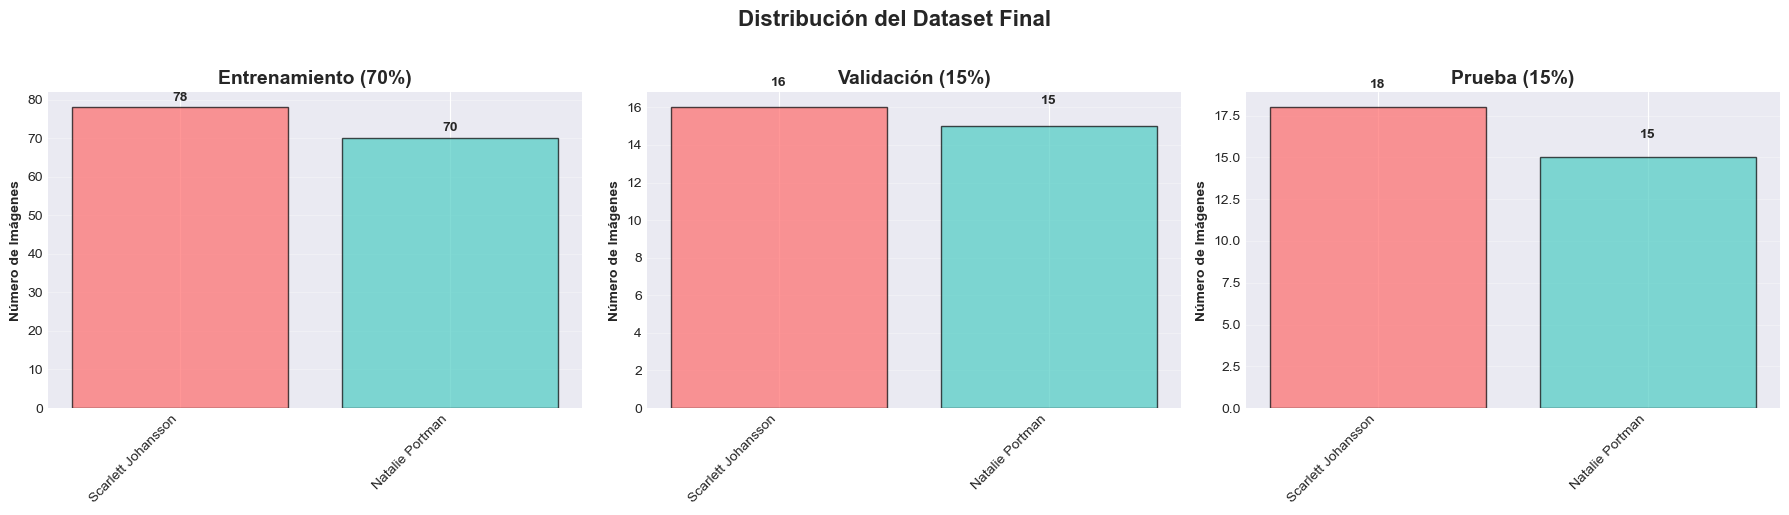

In [15]:

print("\n" + "="*70)
print("PREPARACIÓN DEL DATASET FINAL PARA ENTRENAMIENTO")
print("="*70)

def create_dataset_splits(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Divide el dataset en conjuntos de entrenamiento, validación y prueba
    manteniendo el balance de clases
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Las proporciones deben sumar 1"
    
    np.random.seed(random_state)
    
    train_data = []
    val_data = []
    test_data = []
    
    for label in df['labels'].unique():
        class_data = df[df['labels'] == label].copy()
        class_data = class_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
        
        n = len(class_data)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)
        
        train_data.append(class_data[:train_end])
        val_data.append(class_data[train_end:val_end])
        test_data.append(class_data[val_end:])
    
    train_df = pd.concat(train_data, ignore_index=True).sample(frac=1, random_state=random_state)
    val_df = pd.concat(val_data, ignore_index=True).sample(frac=1, random_state=random_state)
    test_df = pd.concat(test_data, ignore_index=True).sample(frac=1, random_state=random_state)
    
    return train_df, val_df, test_df

# Crear splits
train_df, val_df, test_df = create_dataset_splits(df_clean)

print(f"\n DIVISIÓN DEL DATASET:")
print(f"  Entrenamiento: {len(train_df)} imágenes (70%)")
print(f"  Validación:    {len(val_df)} imágenes (15%)")
print(f"  Prueba:        {len(test_df)} imágenes (15%)")

print(f"\n DISTRIBUCIÓN POR CLASE EN CADA CONJUNTO:")
for dataset_name, dataset in [('Entrenamiento', train_df), ('Validación', val_df), ('Prueba', test_df)]:
    print(f"\n{dataset_name}:")
    dist = dataset['labels'].value_counts()
    for label, count in dist.items():
        percentage = (count / len(dataset)) * 100
        print(f"  {label:20s}: {count:3d} ({percentage:.1f}%)")

# Visualizar distribución final
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [train_df, val_df, test_df]
titles = ['Entrenamiento (70%)', 'Validación (15%)', 'Prueba (15%)']
colors = ['#FF6B6B', '#4ECDC4']

for ax, data, title in zip(axes, datasets, titles):
    dist = data['labels'].value_counts()
    ax.bar(range(len(dist)), dist.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(dist)))
    ax.set_xticklabels(dist.index, rotation=45, ha='right')
    ax.set_ylabel('Número de Imágenes', fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for i, val in enumerate(dist.values):
        ax.text(i, val + 1, str(val), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Distribución del Dataset Final', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


FUNCIONES DE CARGA DE DATOS LISTAS

 Uso del generador de batches:
  batch_gen = load_preprocessed_batch(train_df, batch_size=32, augment=True)
  for images, labels in batch_gen:
      # Entrenar modelo con este batch

 Generando un batch de ejemplo...

 Batch generado:
  Shape de imágenes: (8, 224, 224, 3)
  Shape de etiquetas: (8,)
  Rango de valores de imagen: [-1.94, 2.50]
  Etiquetas en el batch: [0 1 0 1 1 0 0 1]


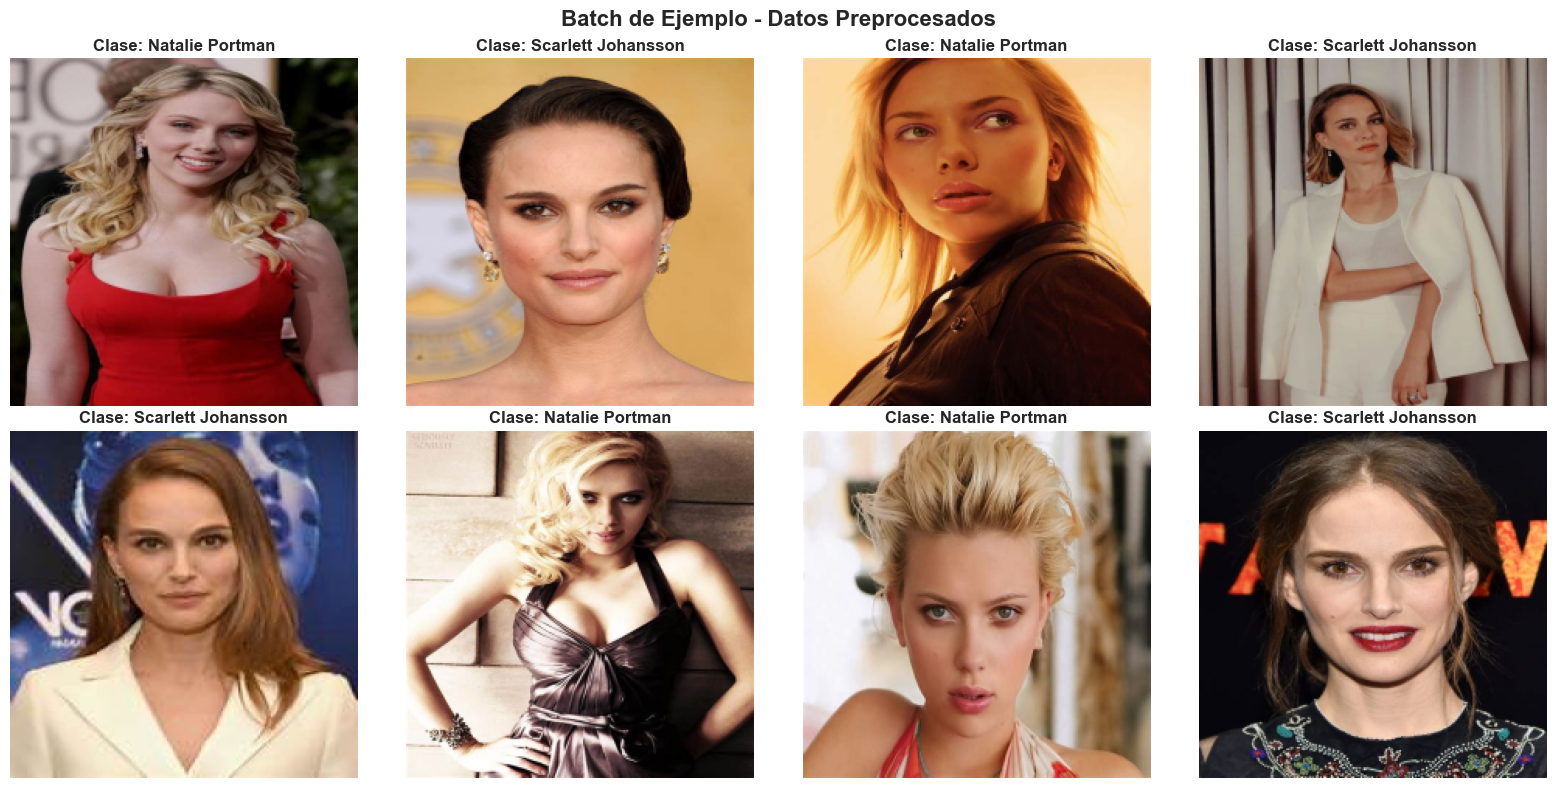

In [17]:
def load_preprocessed_batch(df, batch_size=32, augment=False, shuffle=True):
    """
    Generador de batches de datos preprocesados
    
    Args:
        df: DataFrame con paths y labels
        batch_size: Tamaño del batch
        augment: Si True, aplica data augmentation
        shuffle: Si True, mezcla los datos
    
    Yields:
        (images, labels): Batch de imágenes y etiquetas
    """
    # Mapeo de etiquetas a índices
    label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
    
    indices = np.arange(len(df))
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, len(df), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        batch_df = df.iloc[batch_indices]
        
        images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            # Preprocesar imagen
            img = preprocess_image(row['paths'], normalize=True)
            
            if img is not None:
                # Aplicar augmentation si se solicita
                if augment:
                    augmented = ImageAugmentor.augment_image(img, num_augmentations=1)
                    img = augmented[0]
                
                images.append(img)
                labels.append(label_map[row['labels']])
        
        if images:
            yield np.array(images), np.array(labels)

print("\n" + "="*70)
print("FUNCIONES DE CARGA DE DATOS LISTAS")
print("="*70)
print("\n Uso del generador de batches:")
print("  batch_gen = load_preprocessed_batch(train_df, batch_size=32, augment=True)")
print("  for images, labels in batch_gen:")
print("      # Entrenar modelo con este batch")

# Demostración del generador
print("\n Generando un batch de ejemplo...")
batch_gen = load_preprocessed_batch(train_df, batch_size=8, augment=False, shuffle=True)
sample_images, sample_labels = next(batch_gen)

print(f"\n Batch generado:")
print(f"  Shape de imágenes: {sample_images.shape}")
print(f"  Shape de etiquetas: {sample_labels.shape}")
print(f"  Rango de valores de imagen: [{sample_images.min():.2f}, {sample_images.max():.2f}]")
print(f"  Etiquetas en el batch: {sample_labels}")

# Visualizar el batch
label_names = {0: CLASSES[0], 1: CLASSES[1]}

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx in range(min(8, len(sample_images))):
    # Desnormalizar para visualización
    img_vis = sample_images[idx] * NORMALIZE_STD + NORMALIZE_MEAN
    img_vis = np.clip(img_vis, 0, 1)
    
    axes[idx].imshow(img_vis)
    axes[idx].set_title(f'Clase: {label_names[sample_labels[idx]]}', 
                       fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Batch de Ejemplo - Datos Preprocesados', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
print("\n" + "="*70)
print("GUARDAR DATASET PROCESADO")
print("="*70)

# Guardar información del dataset limpio
output_dir = "processed_dataset"
os.makedirs(output_dir, exist_ok=True)

# Guardar DataFrames
train_df.to_csv(os.path.join(output_dir, 'train_data.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'val_data.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_data.csv'), index=False)

# Guardar estadísticas para normalización
normalization_stats = {
    'mean_rgb': global_mean,
    'std_rgb': global_std,
    'target_size': TARGET_SIZE,
    'label_map': {label: idx for idx, label in enumerate(CLASSES)}
}

import json
with open(os.path.join(output_dir, 'normalization_stats.json'), 'w') as f:
    json.dump(normalization_stats, f, indent=4)

print(f"\n Archivos guardados en '{output_dir}/':")
print(f"  - train_data.csv ({len(train_df)} imágenes)")
print(f"  - val_data.csv ({len(val_df)} imágenes)")
print(f"  - test_data.csv ({len(test_df)} imágenes)")
print(f"  - normalization_stats.json")


GUARDAR DATASET PROCESADO

 Archivos guardados en 'processed_dataset/':
  - train_data.csv (148 imágenes)
  - val_data.csv (31 imágenes)
  - test_data.csv (33 imágenes)
  - normalization_stats.json
